# Translate signal in MRS band 1B to band 3A
In this notebook we use the DISTORTION maps to translate the signal of a point source observation in band 1B to the half of the detector belonging to MRS band 3A. This is done by interpolating the signal of band 1B and then using the alpha distortion map to do the signal mapping.

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from astropy.convolution import convolve
import scipy.interpolate as scp_interpolate
from astropy.io import fits
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# MRS spectral bands and detector pixel dimensions
bands = ["1B","3A"]
test_campaign = 'FM'

In [3]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
if test_campaign == 'FM':
    lvl2path  = workDir+'FM_data/LVL2/'
elif test_campaign == 'OTIS':
    lvl2path  = workDir+'OTIS_data/LVL2/'
MRSWaveCalDir = workDir+"MRSWaveCal/" 
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
MrsFilterTransmDir   = MRSWaveCalDir+"MrsFilterTransmissions/"

In [65]:
# load CDPs
fringe_img,fringe_err,photom_img,photom_err,psffits,specres_table = [{} for i in range(6)]
d2cMaps = {}
point_source_bkgsubtr,point_source_divfringe,point_source_divphotom = {},{},{}
lambcens,lambfwhms = {},{}
for band in bands:
    fringe_file,photom_file,psf_file,resol_file,pce_file = funcs.get_cdps(band,cdpDir,output='filepath')

    fringe_img[band],fringe_err[band] = fits.open(fringe_file)[1].data,fits.open(fringe_file)[2].data # [unitless]
    photom_img[band],photom_err[band] = fits.open(photom_file)[1].data,fits.open(fringe_file)[2].data # [DN/s * pixel/mJy]
    specres_table[band] = fits.open(resol_file)[1].data   # [unitless]
    
    d2cMaps[band] = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)
    
    if test_campaign == 'FM':
        point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_RAD_06_raster(lvl2path,band)
    elif test_campaign == 'OTIS':
        point_source_sci,point_source_bkg = mrsobs.OTIS_ASPA_semiextended_source(lvl2path,band,pointing='v03',output='img')
    point_source_bkgsubtr[band] = point_source_sci-point_source_bkg
    point_source_divfringe[band] = point_source_bkgsubtr[band]/fringe_img[band]
    point_source_divphotom[band] = point_source_divfringe[band]/photom_img[band]
    
    lambcens[band],lambfwhms[band] = funcs.spectral_gridding(band,d2cMaps[band],specres_table=specres_table[band])
    
# Band 3A second order spectrophotometric response (derived in notebook "1b - Save MRS second order response to CDP")
second_order_response = fits.open(cdpDir+'CDP7/MIRI_FM_MIRIFULONG_34SHORT_SECONDORDER_PHOTOM_7B.03.02.fits')[1].data

<IPython.core.display.Javascript object>


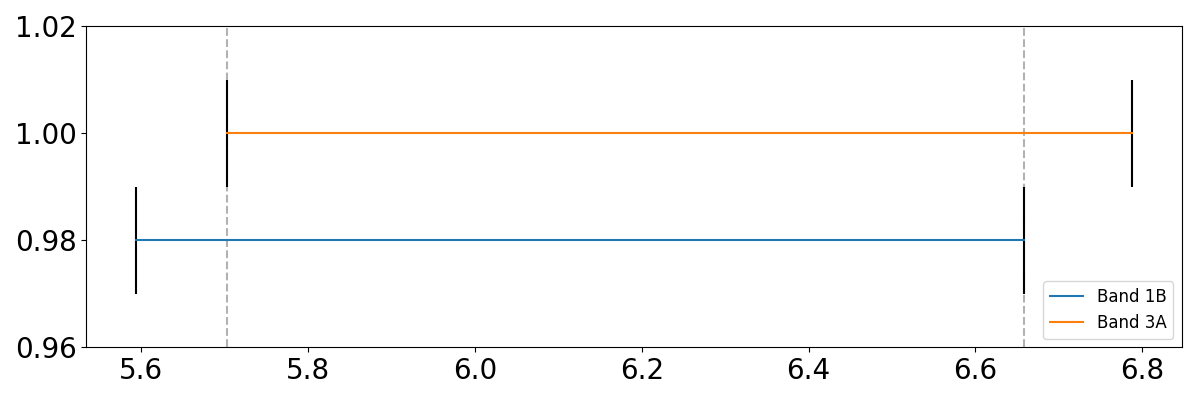

In [66]:
# wavelength overlap
plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],0.98*np.ones(len(lambcens['1B'])),label='Band 1B')
plt.plot(lambcens['3A']/2,np.ones(len(lambcens['3A'])),label='Band 3A')
plt.vlines([lambcens['3A'].min()/2,lambcens['3A'].max()/2],0.99,1.01,'k')
plt.vlines([lambcens['1B'].min(),lambcens['1B'].max()],0.97,0.99,'k')
plt.vlines([lambcens['3A'].min()/2,lambcens['1B'].max()],0.96,1.02,'k',linestyle='dashed',alpha=0.3)
plt.ylim(0.96,1.02)
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()

# index range of spectral overlap between band 1B and band 3A
min_idx_band3A = 0
max_idx_band3A = funcs.find_nearest(lambcens['3A']/2.,lambcens['1B'].max())

<IPython.core.display.Javascript object>


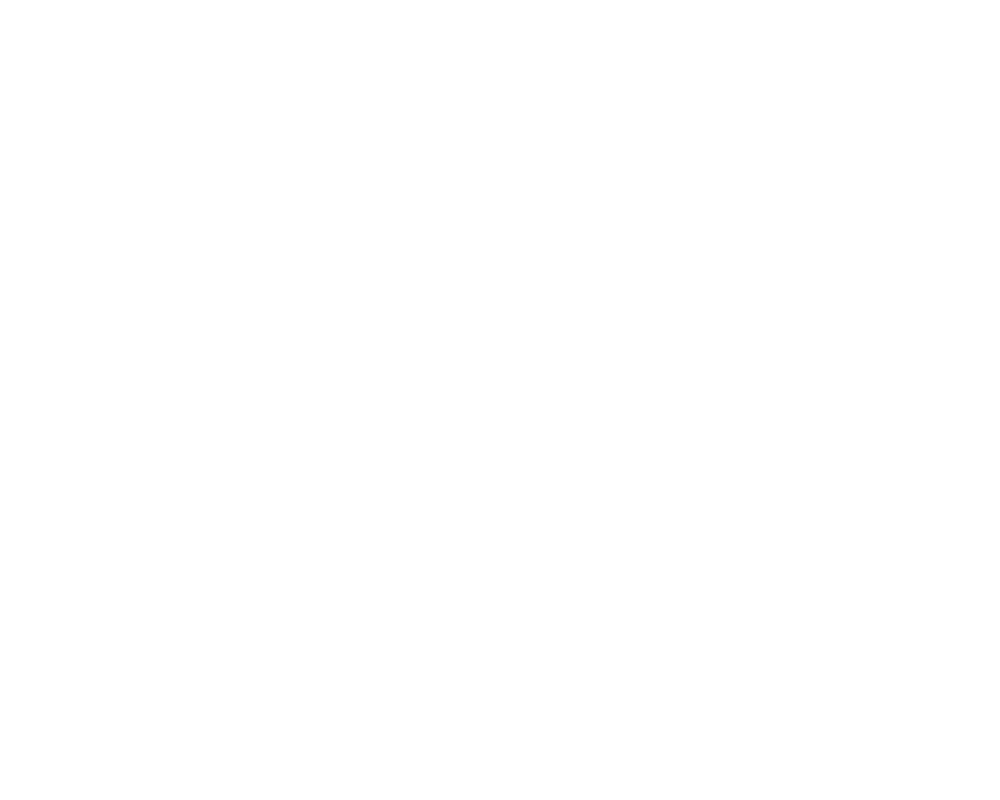

In [6]:
# examine detector slope images
if test_campaign == 'FM':
    vmin,vmax = 0,2
elif test_campaign == 'OTIS':
    vmin,vmax = 0,100
fig,axs = plt.subplots(1,2,figsize=(10,8))
img_1B,sliceMap_1B = point_source_divphotom['1B'].copy(),d2cMaps['1B']['sliceMap'].copy()
img_1B[np.isnan(img_1B)] = 0
sliceMap_1B[np.nonzero(sliceMap_1B)] = 1.
axs[0].imshow(img_1B[:,:512],vmin=vmin,vmax=vmax)
axs[0].imshow(sliceMap_1B[:,:512],alpha=0.2)
axs[0].set_title('Band 1B')
img_3A,sliceMap_3A = point_source_divphotom['3A'].copy(),d2cMaps['3A']['sliceMap'].copy()
img_3A[np.isnan(img_3A)] = 0
sliceMap_3A[np.nonzero(sliceMap_3A)] = 1.
axs[1].imshow(img_3A[:,512:],vmin=vmin,vmax=vmax)
axs[1].imshow(sliceMap_3A[:,512:],alpha=0.2)
axs[1].set_title('Band 3A')
plt.tight_layout()

In [7]:
ypos,xpos = funcs.detpixel_trace_compactsource(point_source_divfringe['3A'],'3A',d2cMaps['3A'])

In [8]:
# fit Gaussian profile to (semi-extended) sources
sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta,bkg_signal = [{} for i in range(6)]

sign_amp['1B'],alpha_centers['1B'],beta_centers['1B'],sigma_alpha['1B'],sigma_beta['1B'],bkg_signal['1B'] = funcs.point_source_centroiding('1B',point_source_divphotom['1B'],d2cMaps['1B'],spec_grid=[lambcens['1B'],lambfwhms['1B']],fit='2D')
sign_amp['3A'],alpha_centers['3A'],beta_centers['3A'],sigma_alpha['3A'],sigma_beta['3A'],bkg_signal['3A'] = funcs.point_source_centroiding('3A',point_source_divfringe['3A'],d2cMaps['3A'],spec_grid=[lambcens['3A'],lambfwhms['3A']],fit='2D')

STEP 1: Rough centroiding
Slice 11 has the largest summed flux
Source position: beta = 0.0arcsec, alpha = -0.33arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 36, 37, 38, 40, 114, 115, 116, 189, 194, 195, 284, 285, 292, 293, 294, 333, 334, 359, 360, 361, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577]
STEP 1: Rough centroiding
Slice 9 has the largest summed flux
Source position: beta = 0.19arcsec, alpha = 0.97arcsec 

STEP 2: 1D Gauss

Band 1B


<IPython.core.display.Javascript object>


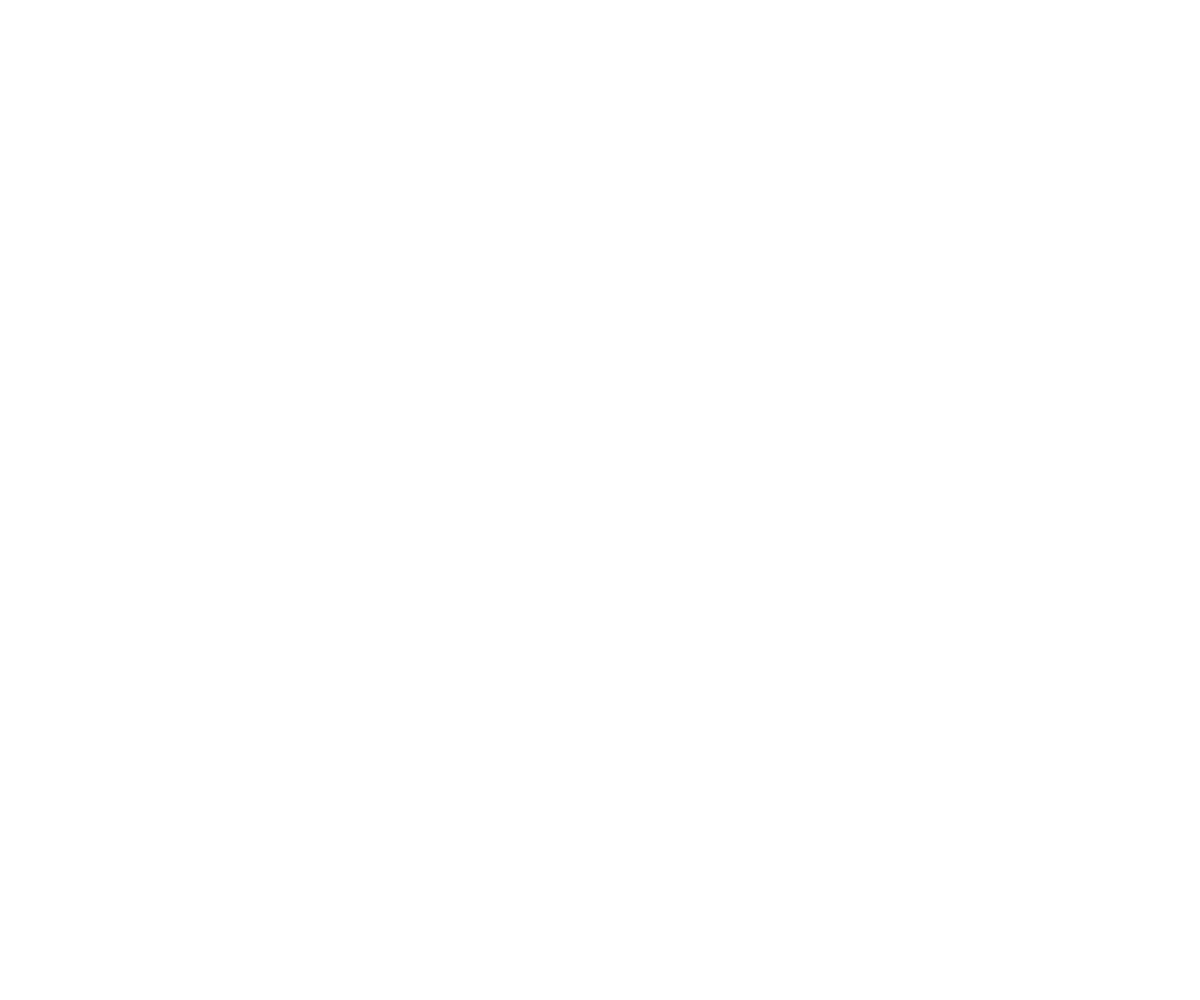

<IPython.core.display.Javascript object>


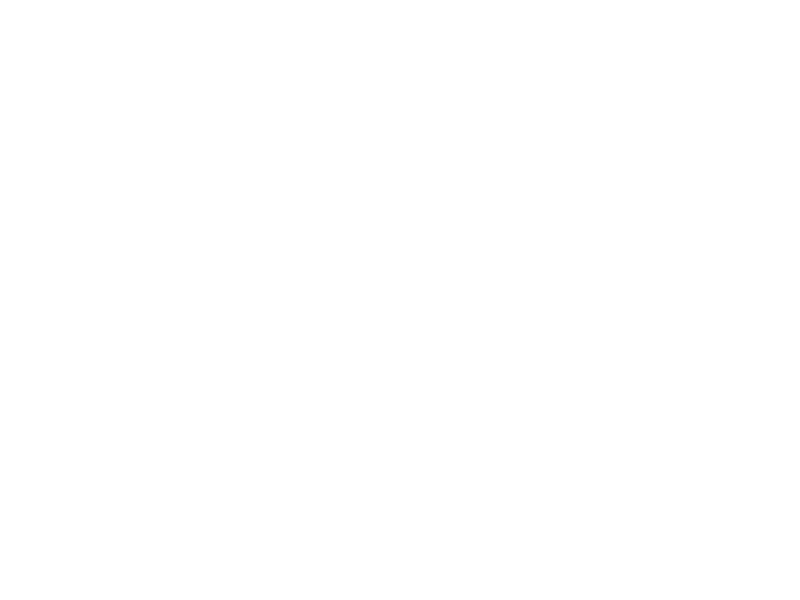

<IPython.core.display.Javascript object>


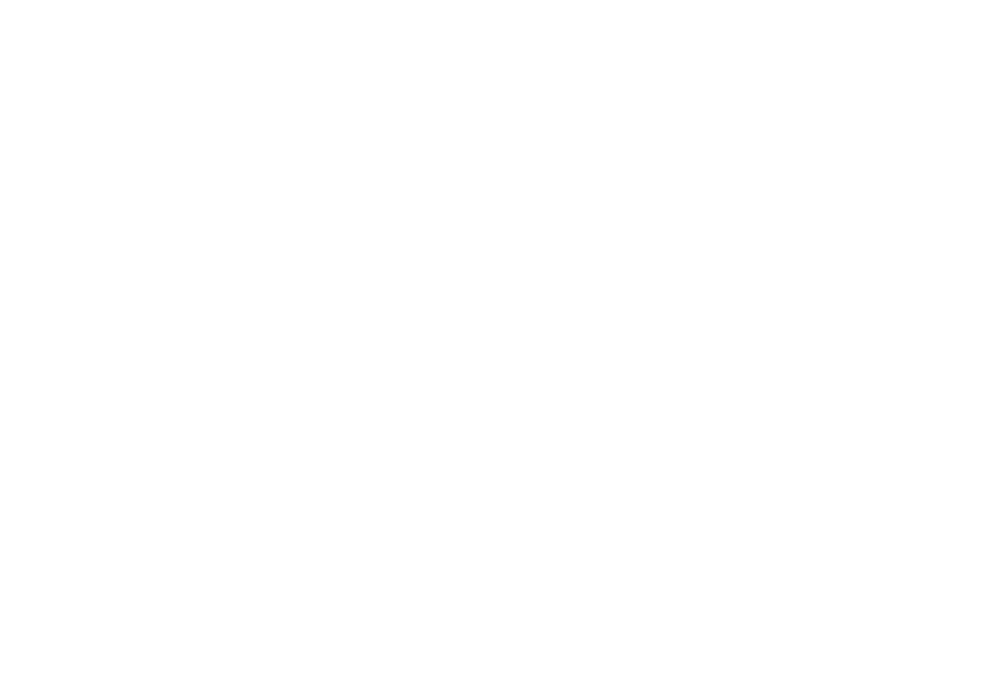

Band 3A


<IPython.core.display.Javascript object>


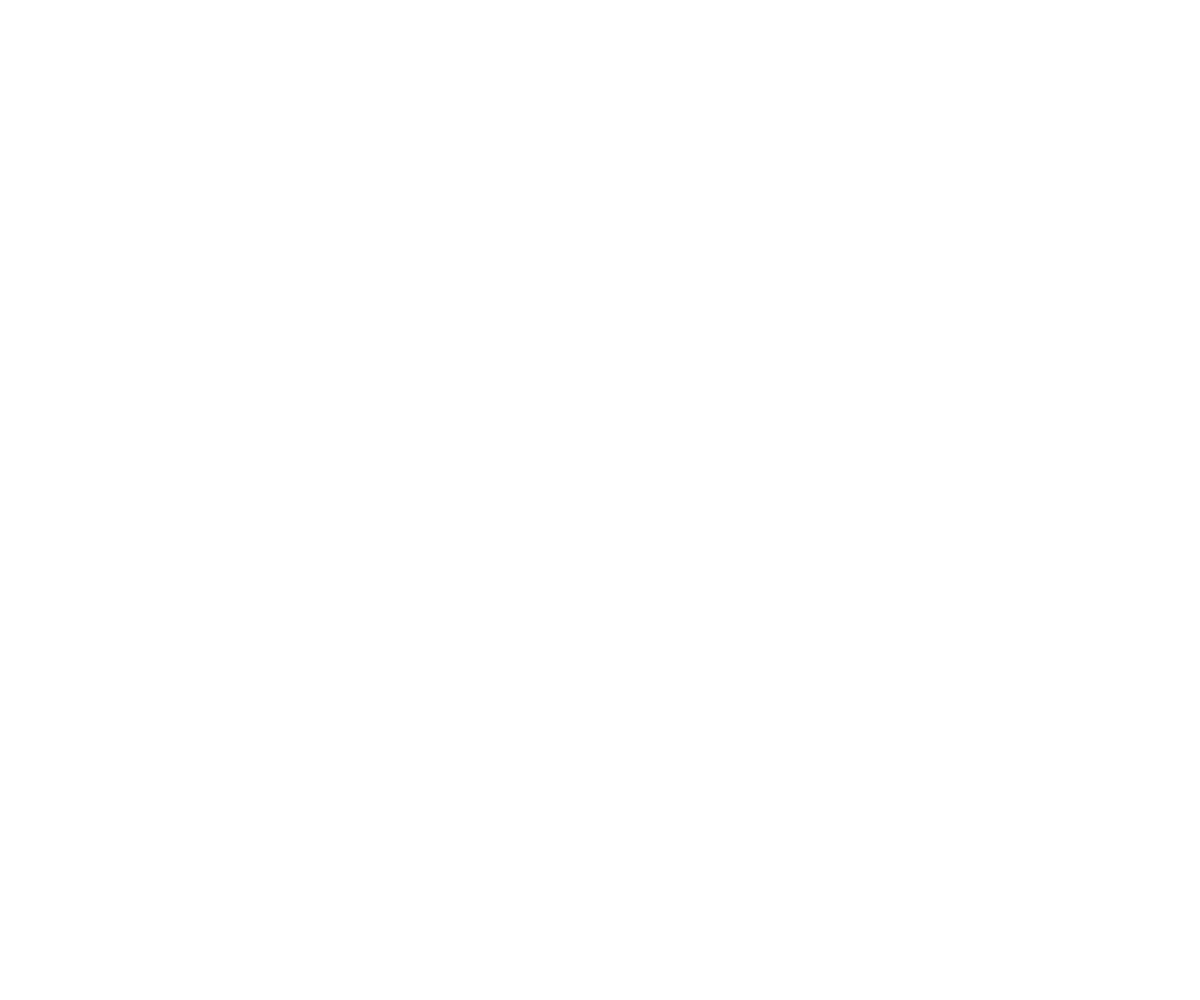

<IPython.core.display.Javascript object>


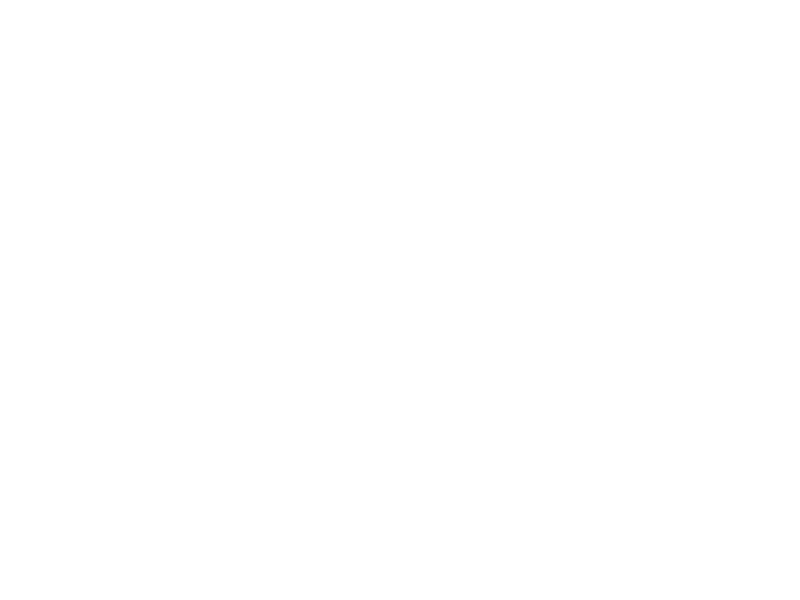

<IPython.core.display.Javascript object>


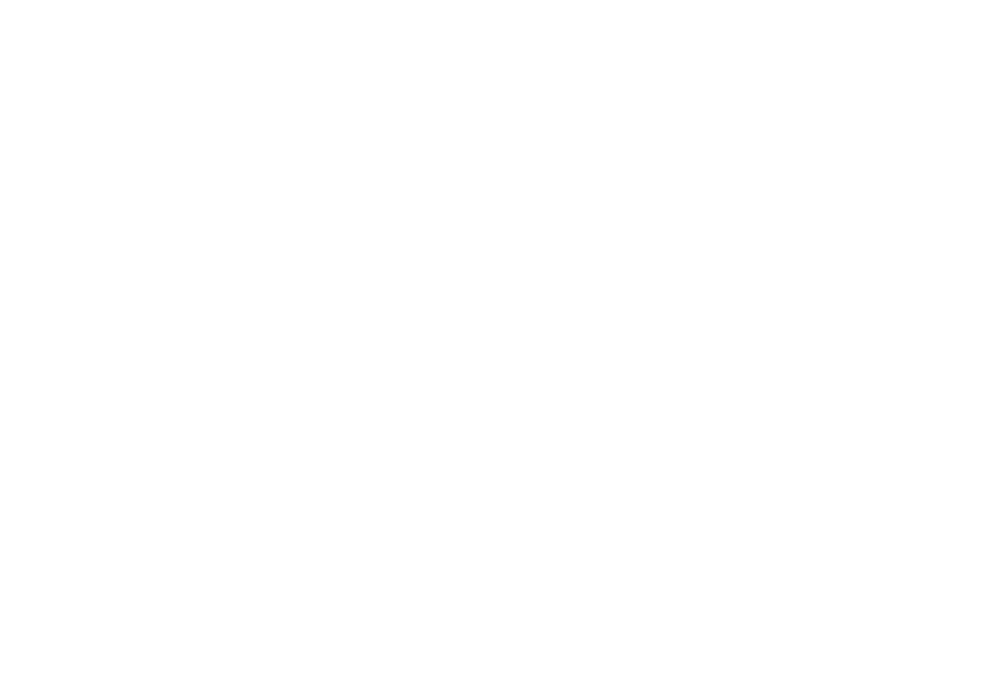

In [9]:
# Review fitting results
print('Band 1B')
funcs.plot_point_source_centroiding('1B',point_source_divphotom['1B'],d2cMaps['1B'],spec_grid=[lambcens['1B'],lambfwhms['1B']],centroid=[sign_amp['1B'],alpha_centers['1B'],beta_centers['1B'],sigma_alpha['1B'],sigma_beta['1B'],bkg_signal['1B']],ibin=100,data='divphotom')
print('Band 3A')
funcs.plot_point_source_centroiding('3A',point_source_divfringe['3A'],d2cMaps['3A'],spec_grid=[lambcens['3A'],lambfwhms['3A']],centroid=[sign_amp['3A'],alpha_centers['3A'],beta_centers['3A'],sigma_alpha['3A'],sigma_beta['3A'],bkg_signal['3A']],ibin=80,data='slope')

<IPython.core.display.Javascript object>


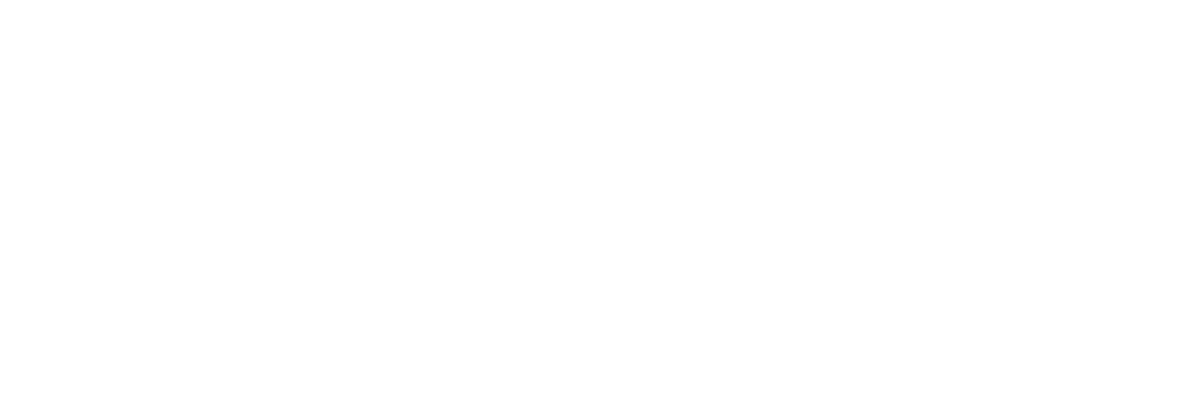

<IPython.core.display.Javascript object>


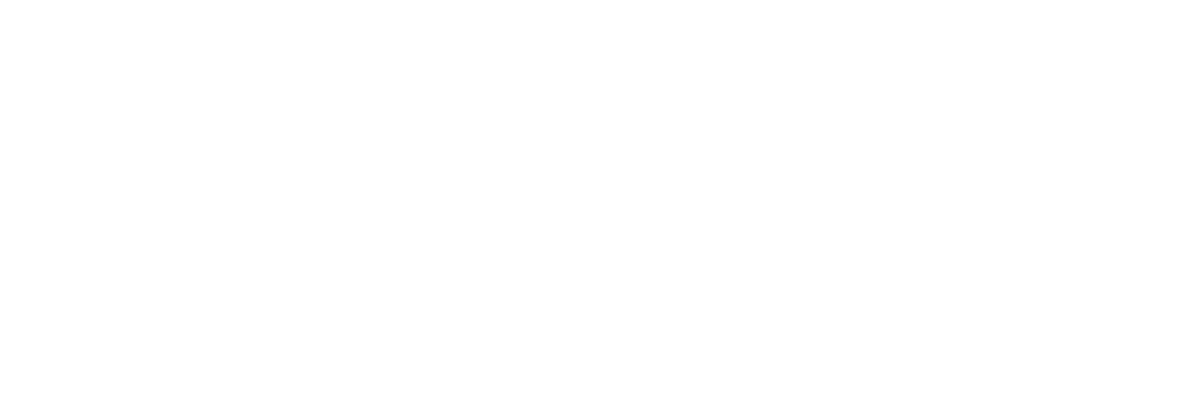

<IPython.core.display.Javascript object>


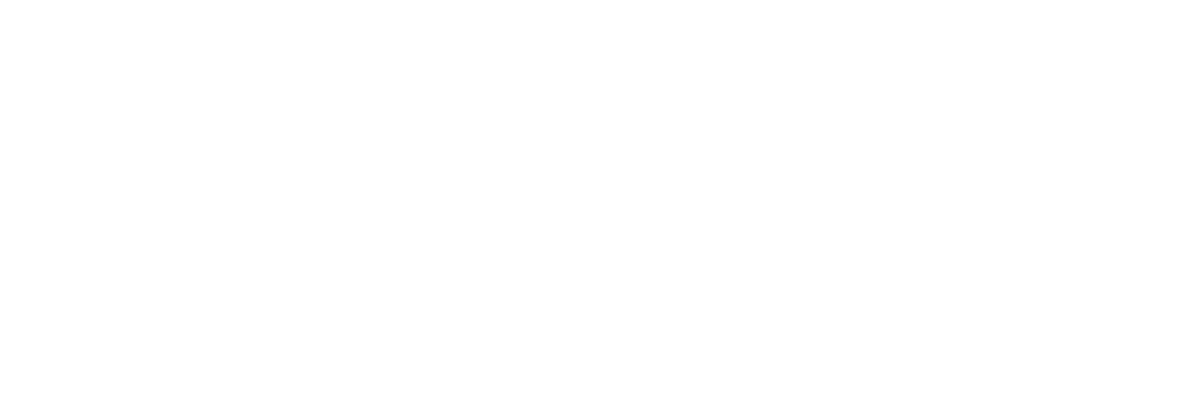

<IPython.core.display.Javascript object>


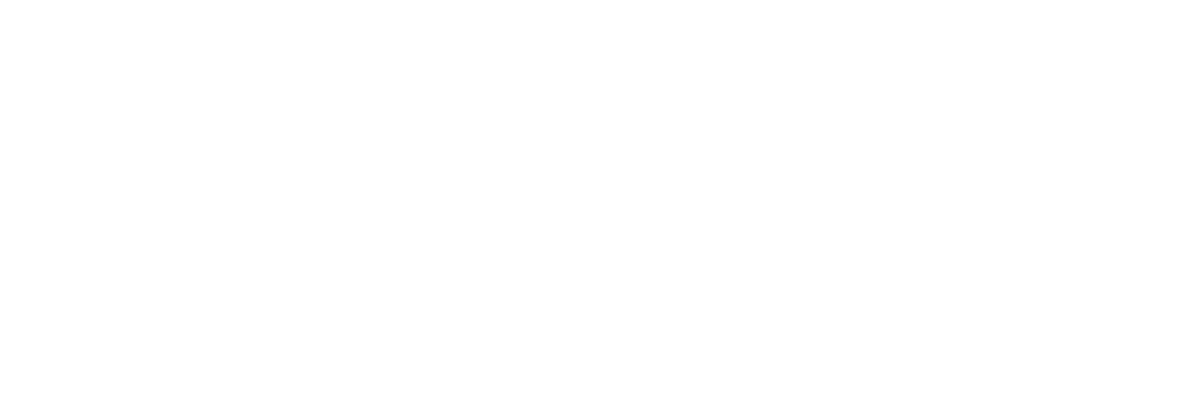

<IPython.core.display.Javascript object>


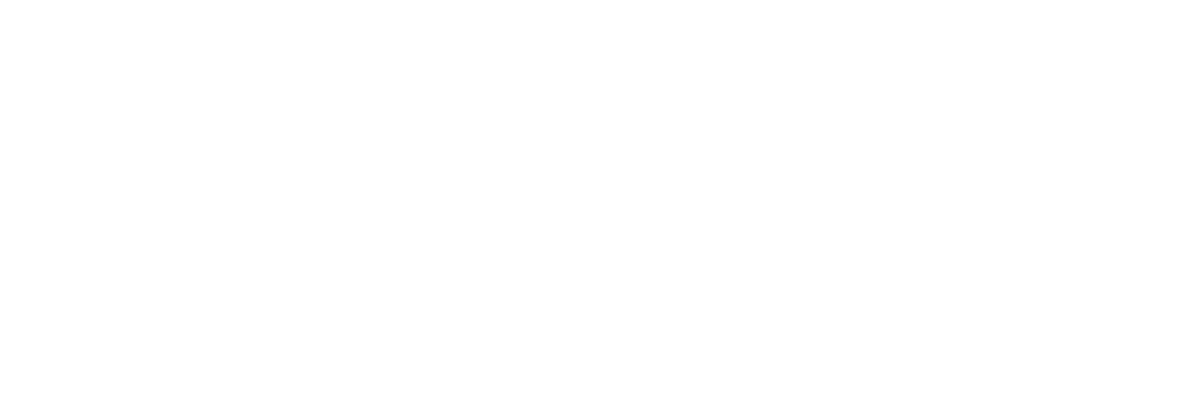

<IPython.core.display.Javascript object>


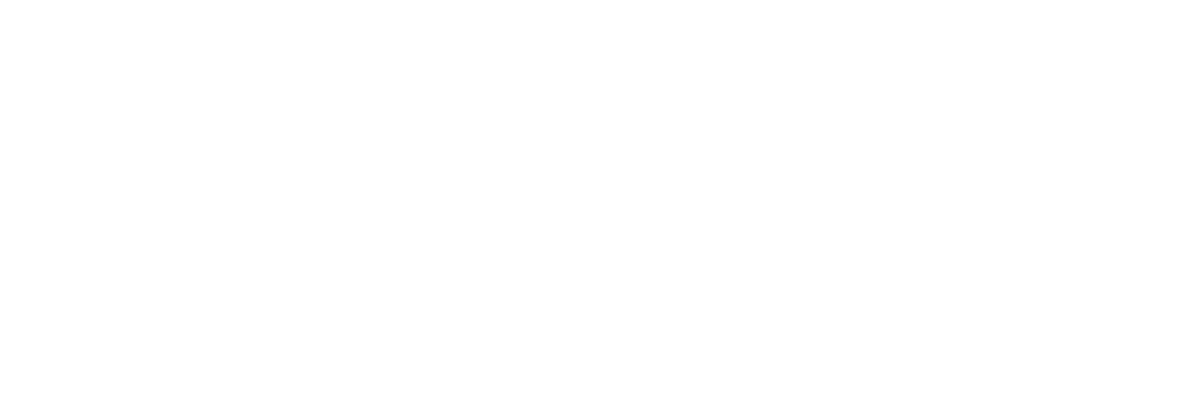

In [10]:
# Manage presence of NaNs by replacing fitted data by fitted polynomials in the spectral dimension
#> signal
sign_amp_poly = {}
sign_amp_poly['1B'] = funcs.norm_fringe(sign_amp['1B'],thres=0,min_dist=4,k=3,ext=3)[2]
sign_amp_poly['3A'] = funcs.norm_fringe(sign_amp['3A'],thres=0,min_dist=8,k=3,ext=3)[2]
    
plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],sign_amp['1B'],label='Band 1B n=1 [mJy/pix]')
plt.plot(lambcens['1B'],sign_amp_poly['1B'])
plt.plot(lambcens['3A']/2.,sign_amp['3A'],label='Band 3A n=2 [DN/sec]')
plt.plot(lambcens['3A']/2.,sign_amp_poly['3A'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('SCI signal')
plt.legend(loc='upper right')
plt.tight_layout()

#> along-slice position
alpha_poly = {}
for band in bands:
    popt     = np.polyfit(lambcens[band][~np.isnan(alpha_centers[band])],alpha_centers[band][~np.isnan(alpha_centers[band])],3)
    poly     = np.poly1d(popt)
    alpha_poly[band] = poly(lambcens[band])

plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],alpha_centers['1B'],label='Band 1B n=1')
plt.plot(lambcens['1B'],alpha_poly['1B'])
plt.plot(lambcens['3A']/2.,alpha_centers['3A'],label='Band 3A n=2')
plt.plot(lambcens['3A']/2.,alpha_poly['3A'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\alpha$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> across-slice position
beta_poly = {}
for band in bands:
    popt     = np.polyfit(lambcens[band][~np.isnan(beta_centers[band])],beta_centers[band][~np.isnan(beta_centers[band])],3)
    poly     = np.poly1d(popt)
    beta_poly[band] = poly(lambcens[band])

plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],beta_centers['1B'],label='Band 1B n=1')
plt.plot(lambcens['1B'],beta_poly['1B'])
plt.plot(lambcens['3A']/2.,beta_centers['3A'],label='Band 3A n=2')
plt.plot(lambcens['3A']/2.,beta_poly['3A'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\beta$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> sigma in along-slice position
sigma_alpha_poly = {}
for band in bands:
    popt     = np.polyfit(lambcens[band][~np.isnan(sigma_alpha[band])],sigma_alpha[band][~np.isnan(sigma_alpha[band])],3)
    poly     = np.poly1d(popt)
    sigma_alpha_poly[band] = poly(lambcens[band])

plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],sigma_alpha['1B'],label='Band 1B n=1')
plt.plot(lambcens['1B'],sigma_alpha_poly['1B'])
plt.plot(lambcens['3A']/2.,sigma_alpha['3A'],label='Band 3A n=2')
plt.plot(lambcens['3A']/2.,sigma_alpha_poly['3A'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\sigma_{\alpha}$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> sigma in across-slice position
sigma_beta_poly = {}
for band in bands:
    popt     = np.polyfit(lambcens[band][~np.isnan(sigma_beta[band])],sigma_beta[band][~np.isnan(sigma_beta[band])],3)
    poly     = np.poly1d(popt)
    sigma_beta_poly[band] = poly(lambcens[band])

plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],sigma_beta['1B'],label='Band 1B n=1')
plt.plot(lambcens['1B'],sigma_beta_poly['1B'])
plt.plot(lambcens['3A']/2.,sigma_beta['3A'],label='Band 3A n=2')
plt.plot(lambcens['3A']/2.,sigma_beta_poly['3A'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\sigma_{\beta}$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> background/baseline signal
bkg_poly = {}
for band in bands:
    popt     = np.polyfit(lambcens[band][~np.isnan(bkg_signal[band])],bkg_signal[band][~np.isnan(bkg_signal[band])],3)
    poly     = np.poly1d(popt)
    bkg_poly[band] = poly(lambcens[band])

plt.figure(figsize=(12,4))
plt.plot(lambcens['1B'],bkg_signal['1B'],label='Band 1B n=1 [mJy/pix]')
plt.plot(lambcens['1B'],bkg_poly['1B'])
plt.plot(lambcens['3A']/2.,bkg_signal['3A'],label='Band 3A n=2 [DN/sec]')
plt.plot(lambcens['3A']/2.,bkg_poly['3A'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('BKG signal')
plt.legend(loc='best')
plt.tight_layout()

<IPython.core.display.Javascript object>


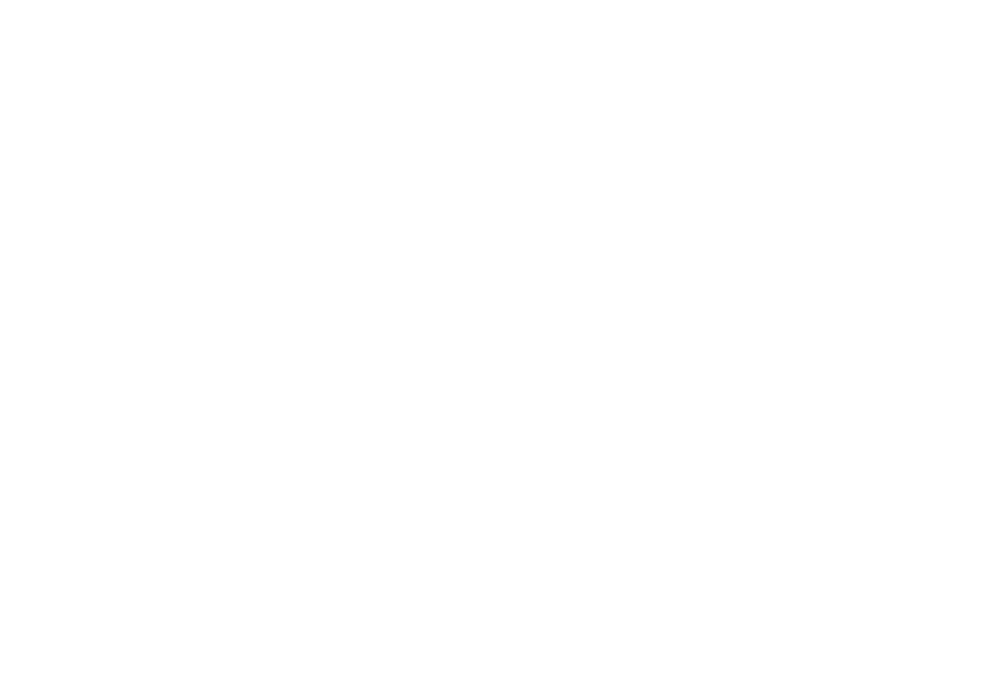

In [11]:
# Compare 2D Gaussian fits
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

unique_betas = np.sort(np.unique(d2cMaps['1B']['betaMap'][(d2cMaps['1B']['sliceMap']>100*int('1')) & (d2cMaps['1B']['sliceMap']<100*(int('1')+1))]))
fov_lims  = [d2cMaps['1B']['alphaMap'][np.nonzero(d2cMaps['1B']['lambdaMap'])].min(),d2cMaps['1B']['alphaMap'][np.nonzero(d2cMaps['1B']['lambdaMap'])].max()]

# initial guess for fitting, informed by previous centroiding steps
bin_3A = 150
bin_1B = funcs.find_nearest(lambcens['1B'],lambcens['3A'][bin_3A]/2)

amp,alpha0,beta0  = sign_amp_poly['1B'][bin_1B], alpha_poly['1B'][bin_1B], beta_poly['1B'][bin_1B]
sigma_alpha0, sigma_beta0 = sigma_alpha_poly['1B'][bin_1B], sigma_beta_poly['1B'][bin_1B]
base = bkg_poly['1B'][bin_1B]
guess = [amp, alpha0, beta0, sigma_alpha0, sigma_beta0, base]

bounds = ([0,-np.inf,-np.inf,0,0,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

# data to fit
coords = (np.abs(d2cMaps['1B']['lambdaMap']-lambcens['1B'][bin_1B])<lambfwhms['1B'][bin_1B]/2.)
alphas, betas, zobs   = d2cMaps['1B']['alphaMap'][coords],d2cMaps['1B']['betaMap'][coords],point_source_divphotom['1B'][coords]
alphabetas = np.array([alphas,betas])

# projected grid
betai, alphai = np.mgrid[unique_betas.min():unique_betas.max():300j, fov_lims[0]:fov_lims[1]:300j]
alphabetai = np.vstack([alphai.ravel(), betai.ravel()])

zpred_1B = funcs.gauss2d(alphabetai, *guess)
zpred_1B.shape = alphai.shape

ax.plot_wireframe(alphai,betai, zpred_1B,color='b',alpha=1,label='band 1B fit [mJy/pix]')

amp,alpha0,beta0  = sign_amp_poly['3A'][bin_3A],alpha_poly['3A'][bin_3A],beta_poly['3A'][bin_3A]
sigma_alpha0, sigma_beta0 = sigma_alpha_poly['3A'][bin_3A], sigma_beta_poly['3A'][bin_3A]
guess = [amp, alpha0, beta0, sigma_alpha0, sigma_beta0, base]

zpred_3A = funcs.gauss2d(alphabetai, *guess)
zpred_3A.shape = alphai.shape

ax.plot_wireframe(alphai,betai, zpred_3A,color='r',alpha=0.3,label='band 3A fit [DN/sec]')

ax.tick_params(axis='both',labelsize=10)
ax.set_xlabel(r'$\alpha$ [arcsec]',fontsize=14)
ax.set_ylabel(r'$\beta$ [arcsec]',fontsize=14)
ax.set_zlabel(r'Signal',fontsize=14)
ax.legend(fontsize=12,loc='best')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

<IPython.core.display.Javascript object>


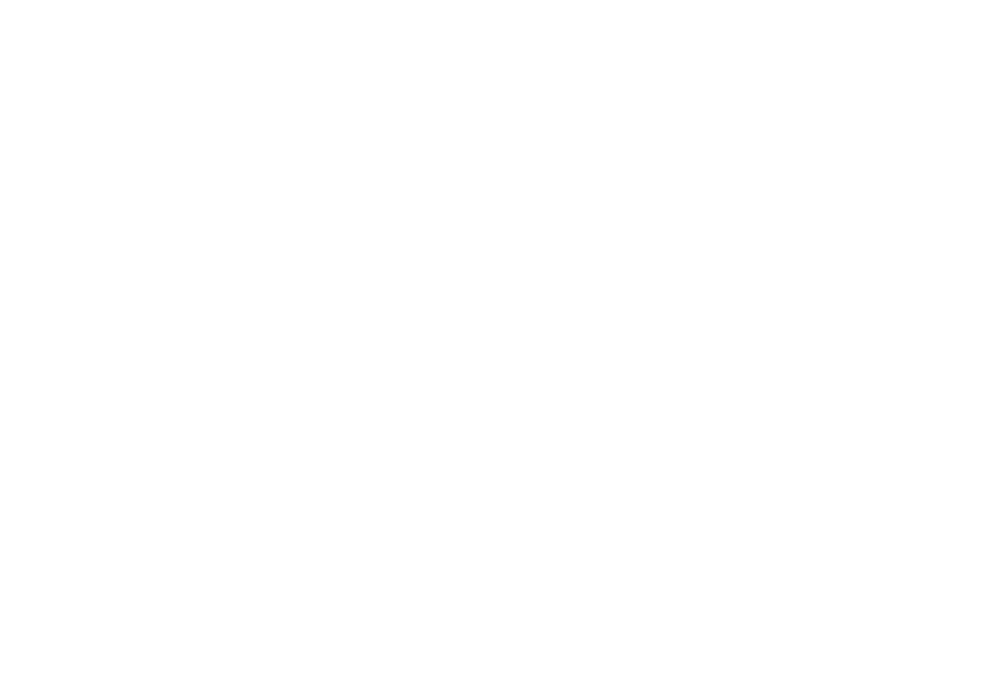

In [12]:
# Compare 2D Gaussian fits
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')

unique_betas = np.sort(np.unique(d2cMaps['1B']['betaMap'][(d2cMaps['1B']['sliceMap']>100*int('1')) & (d2cMaps['1B']['sliceMap']<100*(int('1')+1))]))
fov_lims  = [d2cMaps['1B']['alphaMap'][np.nonzero(d2cMaps['1B']['lambdaMap'])].min(),d2cMaps['1B']['alphaMap'][np.nonzero(d2cMaps['1B']['lambdaMap'])].max()]

# initial guess for fitting, informed by previous centroiding steps
bin_3A = 150
bin_1B = funcs.find_nearest(lambcens['1B'],lambcens['3A'][bin_3A]/2)

amp,alpha0,beta0  = sign_amp_poly['1B'][bin_1B], alpha_poly['1B'][bin_1B], beta_poly['1B'][bin_1B]
sigma_alpha0, sigma_beta0 = sigma_alpha_poly['1B'][bin_1B], sigma_beta_poly['1B'][bin_1B]
base = bkg_poly['1B'][bin_1B]
guess = [amp, alpha0, beta0, sigma_alpha0, sigma_beta0, base]

# projected grid
betai, alphai = np.mgrid[unique_betas.min():unique_betas.max():300j, fov_lims[0]:fov_lims[1]:300j]
alphabetai = np.vstack([alphai.ravel(), betai.ravel()])

zpred_1B = funcs.gauss2d(alphabetai, *guess)
zpred_1B.shape = alphai.shape

ax.plot_wireframe((alphai-alpha_poly['1B'][bin_1B])+alpha_poly['3A'][bin_3A],(betai-beta_poly['1B'][bin_1B])+beta_poly['3A'][bin_3A], zpred_1B,color='b',alpha=0.5,label='band 1B fit recentered [mJy/pix]')

amp,alpha0,beta0  = sign_amp_poly['3A'][bin_3A],alpha_poly['3A'][bin_3A],beta_poly['3A'][bin_3A]
sigma_alpha0, sigma_beta0 = sigma_alpha_poly['3A'][bin_3A], sigma_beta_poly['3A'][bin_3A]
guess = [amp, alpha0, beta0, sigma_alpha0, sigma_beta0, base]

zpred_3A = funcs.gauss2d(alphabetai, *guess)
zpred_3A.shape = alphai.shape

ax.plot_wireframe(alphai,betai, zpred_3A,color='r',alpha=0.3,label='band 3A fit [DN/sec]')

ax.tick_params(axis='both',labelsize=10)
ax.set_xlabel(r'$\alpha$ [arcsec]',fontsize=14)
ax.set_ylabel(r'$\beta$ [arcsec]',fontsize=14)
ax.set_zlabel(r'Signal',fontsize=14)
ax.legend(fontsize=12,loc='best')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

<IPython.core.display.Javascript object>


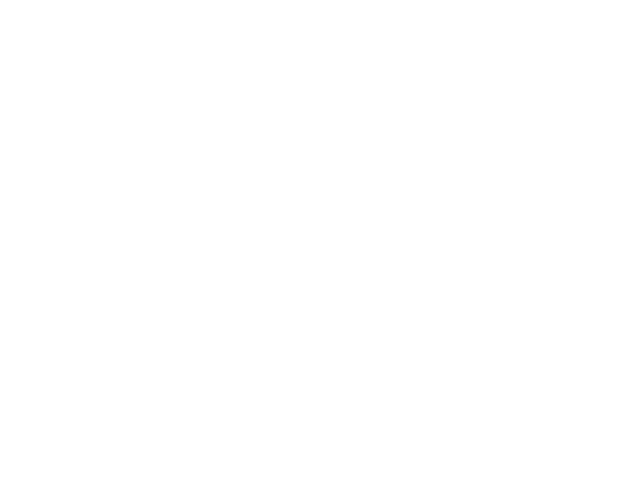

In [13]:
# project band 1B flux on band 3A
img_band1B_projected_on_band3A = np.zeros(point_source_divphotom['3A'].shape)

for bin_3A in range(max_idx_band3A):
    bin_1B = funcs.find_nearest(lambcens['1B'],lambcens['3A'][bin_3A]/2)
    
    coords = (np.abs(d2cMaps['3A']['lambdaMap']-lambcens['3A'][bin_3A])<lambfwhms['3A'][bin_3A]/2.)
    alphas, betas = d2cMaps['3A']['alphaMap'][coords],d2cMaps['3A']['betaMap'][coords]
    
    guess = {}
    guess['1B'] = [sign_amp_poly['1B'][bin_1B], alpha_poly['3A'][bin_3A], beta_poly['3A'][bin_3A], sigma_alpha_poly['1B'][bin_1B], sigma_beta_poly['1B'][bin_1B], bkg_poly['1B'][bin_1B]]
    
    alphabetas = np.array([alphas,betas])
    zpred = funcs.gauss2d(alphabetas, *guess['1B'])
    
    # save output
    img_band1B_projected_on_band3A[coords] = zpred

plt.figure()
plt.imshow(img_band1B_projected_on_band3A)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.tight_layout()

<IPython.core.display.Javascript object>


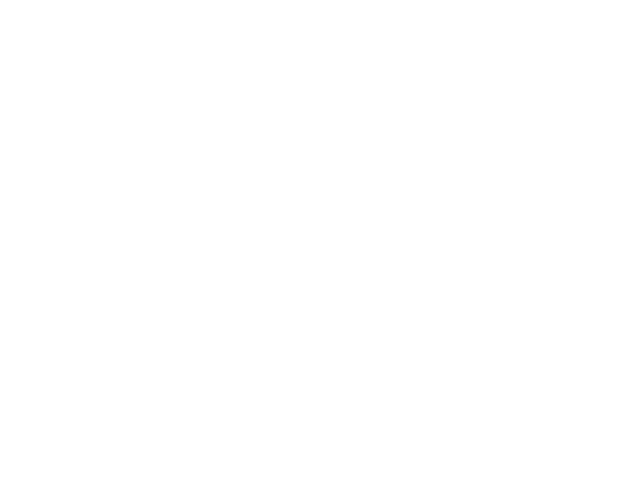

In [14]:
# project band 1B flux on band 3A
img_band1B_projected_on_band3A_interp = np.zeros(point_source_divphotom['3A'].shape)

method = 'linear' # 'nearest','linear','cubic'
# method='cubic' yields only noise
# method='nearest' is not too coarse, since it returns the value at the data point closest to the point of interpolation 
# (which can be quite a ways off, and in fact doesn't perform any interpolation to begin with), thus we settle for method='linear'
for bin_3A in range(max_idx_band3A):
    bin_1B = funcs.find_nearest(lambcens['1B'],lambcens['3A'][bin_3A]/2)
    
    coords = (np.abs(d2cMaps['1B']['lambdaMap']-lambcens['1B'][bin_1B])<lambfwhms['1B'][bin_1B]/2.)
    alphas_1B, betas_1B = d2cMaps['1B']['alphaMap'][coords],d2cMaps['1B']['betaMap'][coords]
    signals_1B = point_source_divphotom['1B'][coords]
    
    # omit nans
    sel = ~np.isnan(signals_1B)
    
    coords = (np.abs(d2cMaps['3A']['lambdaMap']-lambcens['3A'][bin_3A])<lambfwhms['3A'][bin_3A]/2.)
    alphas_3A, betas_3A = d2cMaps['3A']['alphaMap'][coords],d2cMaps['3A']['betaMap'][coords]
    
    grid_z0 = griddata(( (alphas_1B[sel]-alpha_poly['1B'][bin_1B])+alpha_poly['3A'][bin_3A],(betas_1B[sel]-beta_poly['1B'][bin_1B])+beta_poly['3A'][bin_3A]), signals_1B[sel], (alphas_3A, betas_3A), method=method)
    
    # save output
    img_band1B_projected_on_band3A_interp[coords] = grid_z0

if method == 'linear':
    img_band1B_projected_on_band3A_interp[np.isnan(img_band1B_projected_on_band3A_interp)] = 0

plt.figure()
plt.imshow(img_band1B_projected_on_band3A_interp)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.tight_layout()

<IPython.core.display.Javascript object>


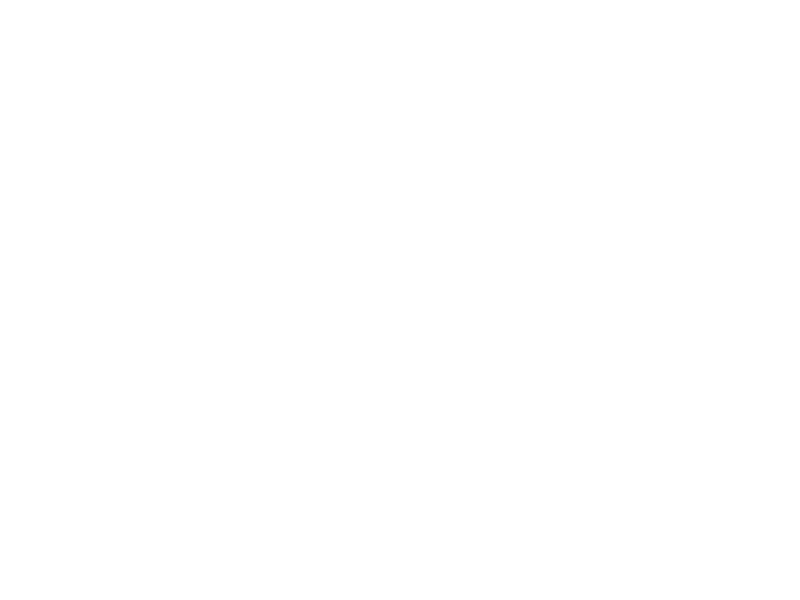

In [15]:
plt.figure(figsize=(8,6))
plt.imshow(img_band1B_projected_on_band3A_interp[:,512:]) #,vmin=0,vmax=0.1
plt.imshow(sliceMap_3A[:,512:],alpha=0.1)
plt.title('Band 1B signal mapped on band 3A')
plt.tight_layout(rect=[0, 0, 1, 1.])

<IPython.core.display.Javascript object>


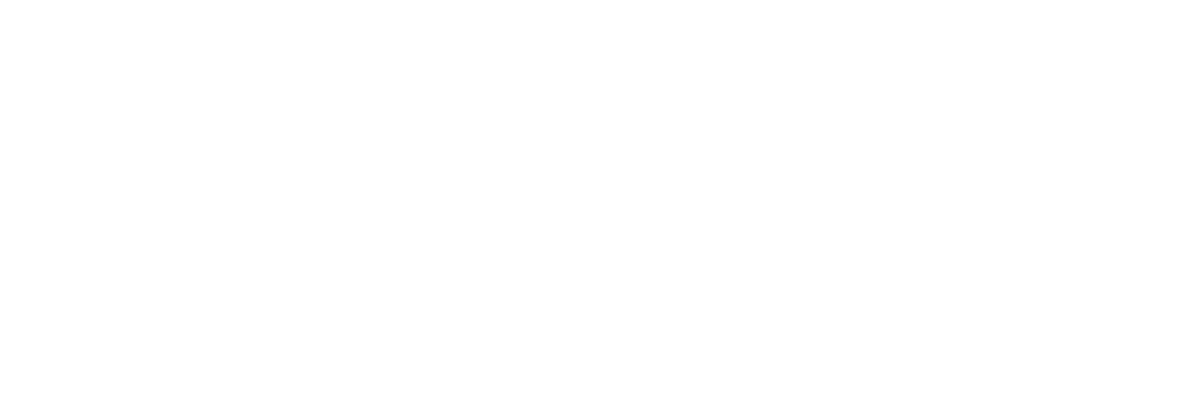

In [16]:
plt.figure(figsize=(12,4))
plt.plot(img_band1B_projected_on_band3A[512,512:])
plt.plot(img_band1B_projected_on_band3A_interp[512,512:])
plt.tight_layout(rect=[0, 0.1, 1, 1.])

<IPython.core.display.Javascript object>


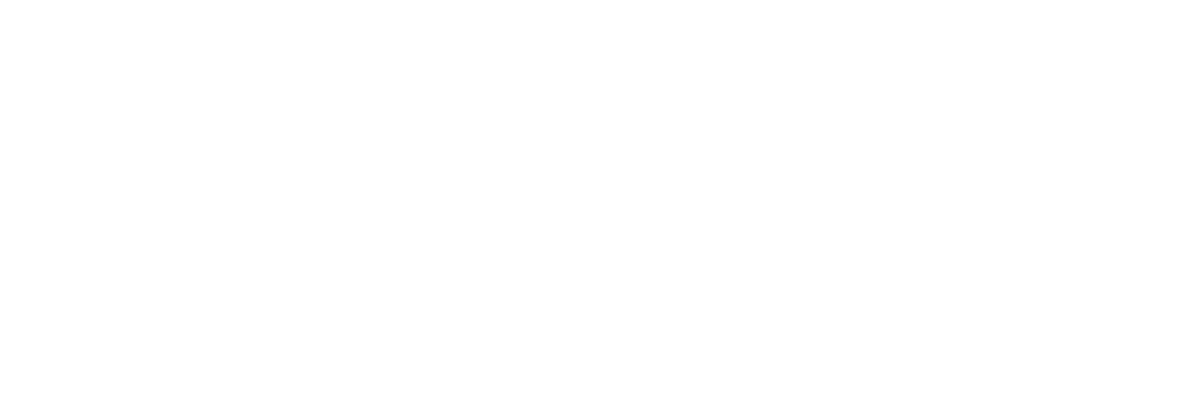

In [17]:
# review 1d projection
plt.figure(figsize=(12,4))
plt.plot(img_band1B_projected_on_band3A_interp[670,512:],label='band 1B signal mapped on band 3A detector plane [mJy/pix]')
plt.plot(point_source_divfringe['3A'][670,512:],label='band 3A [DN/sec]')
plt.xlabel('X-pixel')
plt.ylabel('Signal')
plt.legend(loc='best',fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


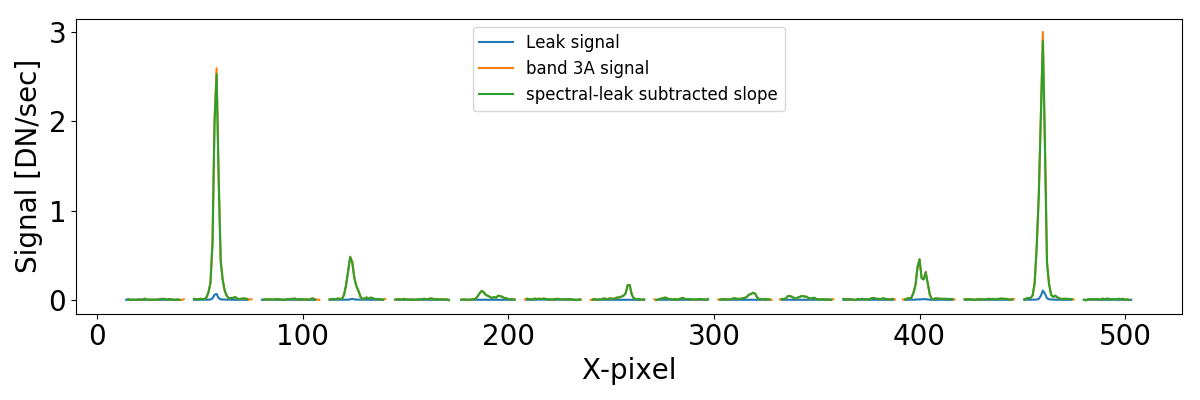

In [68]:
# multiply band 1B flux by second order spectrophotometric response of band 3A
img_band1B_projected_on_band3A_prodphotom = img_band1B_projected_on_band3A_interp*second_order_response

plt.figure(figsize=(12,4))
# plt.plot(img_band1B_projected_on_band3A_prodphotom[550,512:],label='row 550')
plt.plot(img_band1B_projected_on_band3A_prodphotom[670,512:],label='Leak signal')
plt.plot(point_source_divfringe['3A'][670,512:],label='band 3A signal')
plt.plot((point_source_divfringe['3A']-img_band1B_projected_on_band3A_prodphotom)[670,512:],label='spectral-leak subtracted slope')
plt.xlabel('X-pixel')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='best',fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


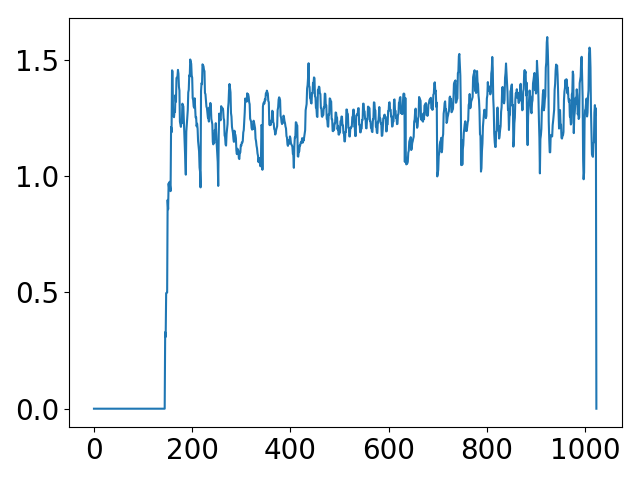

<IPython.core.display.Javascript object>


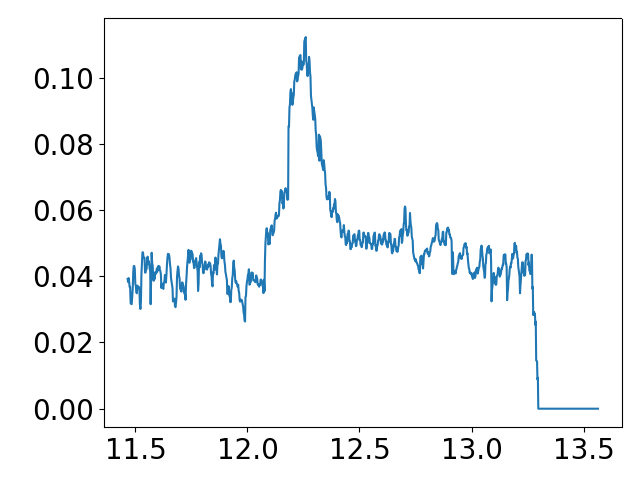

<IPython.core.display.Javascript object>


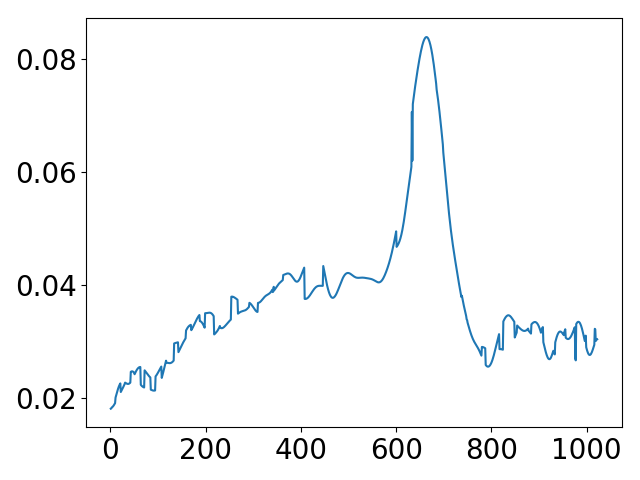

In [69]:
plt.figure()
plt.plot(img_band1B_projected_on_band3A_interp[ypos,xpos])
plt.tight_layout()

plt.figure()
plt.plot(d2cMaps['3A']['lambdaMap'][ypos,xpos],img_band1B_projected_on_band3A_prodphotom[ypos,xpos])
plt.tight_layout()

plt.figure()
plt.plot(second_order_response[ypos,xpos])
plt.tight_layout()

<IPython.core.display.Javascript object>


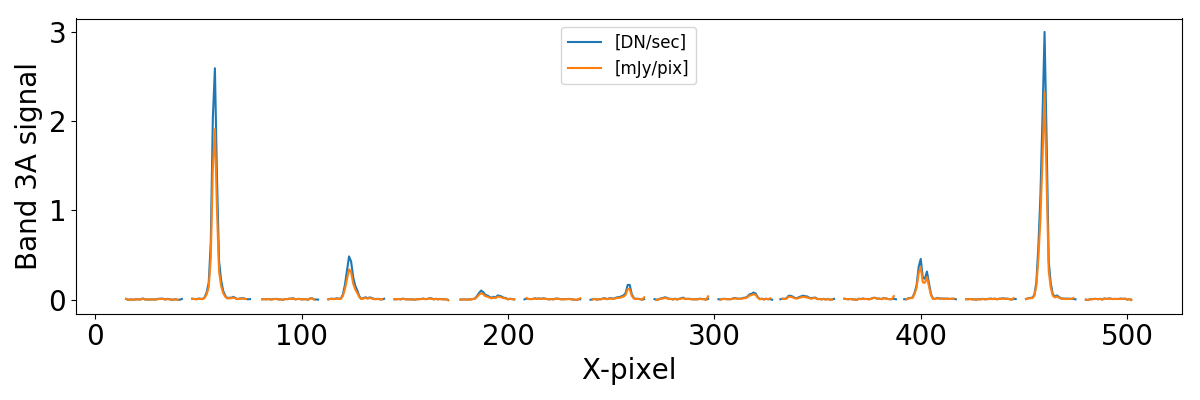

In [70]:
# multiply band 1B flux by second order spectrophotometric response of band 3A
plt.figure(figsize=(12,4))
plt.plot(point_source_divfringe['3A'][670,512:],label='[DN/sec]')
plt.plot(point_source_divphotom['3A'][670,512:],label='[mJy/pix]')
plt.xlabel('X-pixel')
plt.ylabel('Band 3A signal')
plt.legend(loc='best',fontsize=12)
plt.tight_layout()

<IPython.core.display.Javascript object>


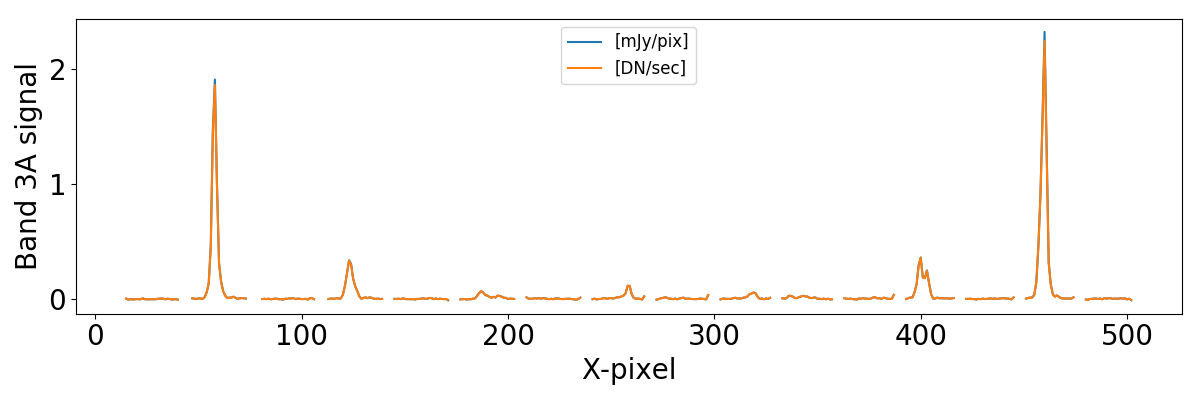

In [71]:
# multiply band 1B flux by second order spectrophotometric response of band 3A
spectrum = point_source_divfringe['3A']/photom_img['3A']
spectrum_leakCorr = (point_source_divfringe['3A']-img_band1B_projected_on_band3A_prodphotom)/photom_img['3A']

plt.figure(figsize=(12,4))
plt.plot(spectrum[670,512:],label='[mJy/pix]')
plt.plot(spectrum_leakCorr[670,512:],label='[DN/sec]')
plt.xlabel('X-pixel')
plt.ylabel('Band 3A signal')
plt.legend(loc='best',fontsize=12)
plt.tight_layout()

In [72]:
# fit Gaussian profile to (semi-extended) sources
sign_amp['3A_noLeakCorr'],alpha_centers['3A_noLeakCorr'],beta_centers['3A_noLeakCorr'],sigma_alpha['3A_noLeakCorr'],sigma_beta['3A_noLeakCorr'],bkg_signal['3A_noLeakCorr'] = funcs.point_source_centroiding('3A',spectrum,d2cMaps['3A'],spec_grid=[lambcens['3A'],lambfwhms['3A']],fit='2D')
sign_amp['3A_LeakCorr'],alpha_centers['3A_LeakCorr'],beta_centers['3A_LeakCorr'],sigma_alpha['3A_LeakCorr'],sigma_beta['3A_LeakCorr'],bkg_signal['3A_LeakCorr'] = funcs.point_source_centroiding('3A',spectrum_leakCorr,d2cMaps['3A'],spec_grid=[lambcens['3A'],lambfwhms['3A']],fit='2D')

STEP 1: Rough centroiding
Slice 9 has the largest summed flux
Source position: beta = 0.19arcsec, alpha = 0.97arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 499, 500]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 29, 30, 31, 32, 40, 41, 42, 52, 53, 54, 64, 65, 66, 78, 79, 93, 94, 110, 159, 160, 161, 162, 166, 167, 168, 169, 213, 214, 215, 216, 217, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 338, 339, 340, 341, 342, 343, 344, 363, 364, 365, 366, 382, 383, 398, 399, 412, 424, 436, 447, 464, 465, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 

<IPython.core.display.Javascript object>


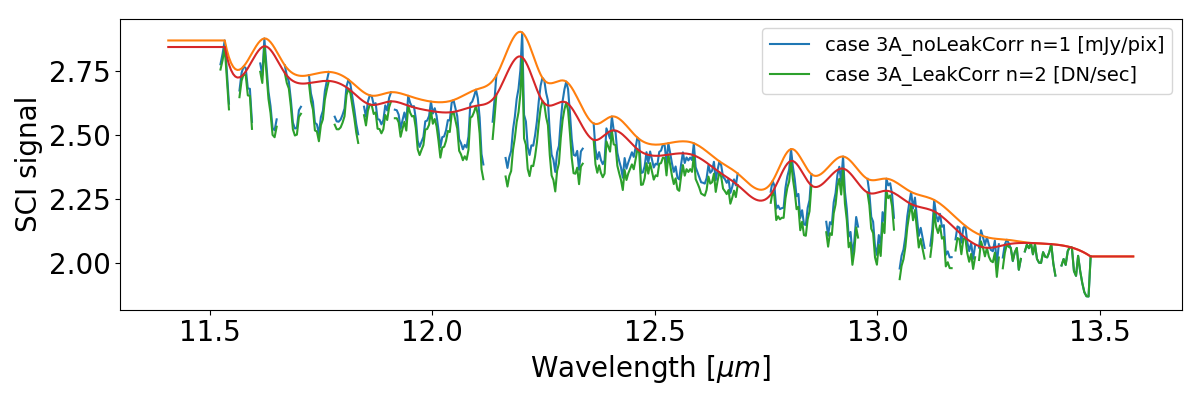

<IPython.core.display.Javascript object>


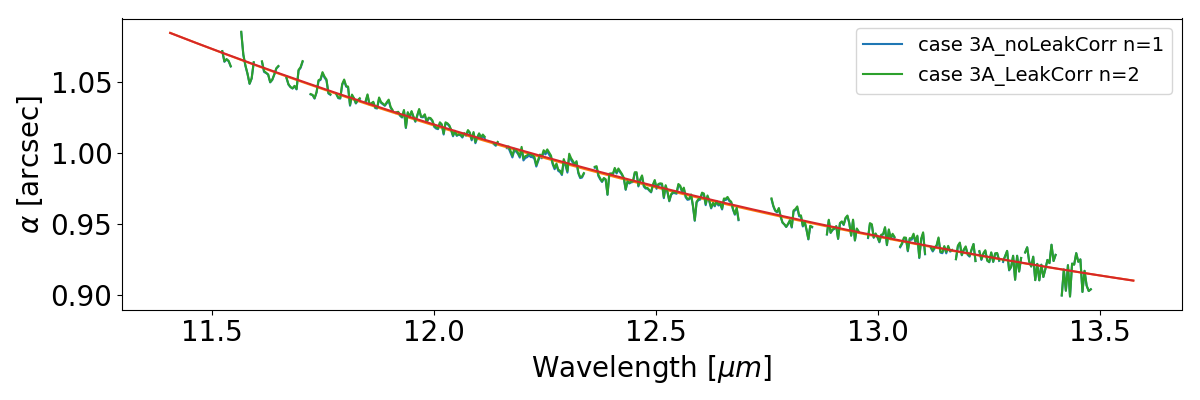

<IPython.core.display.Javascript object>


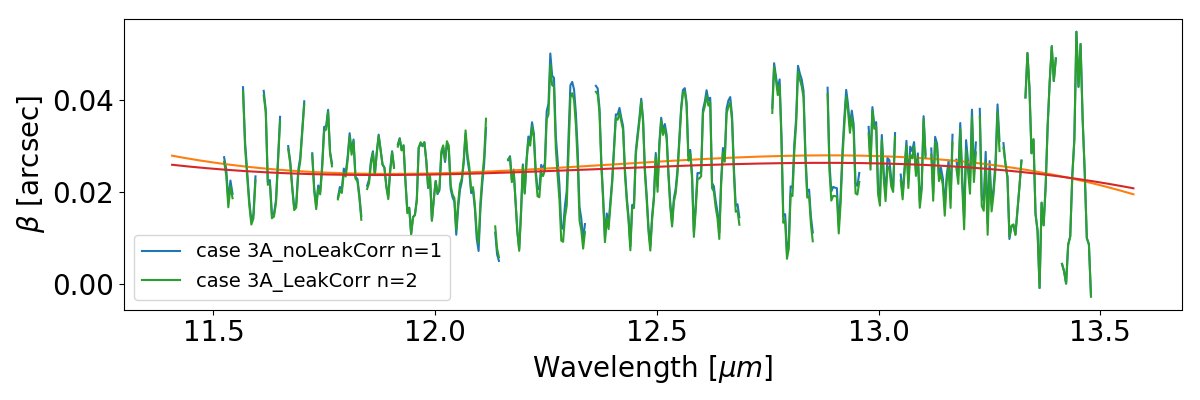

<IPython.core.display.Javascript object>


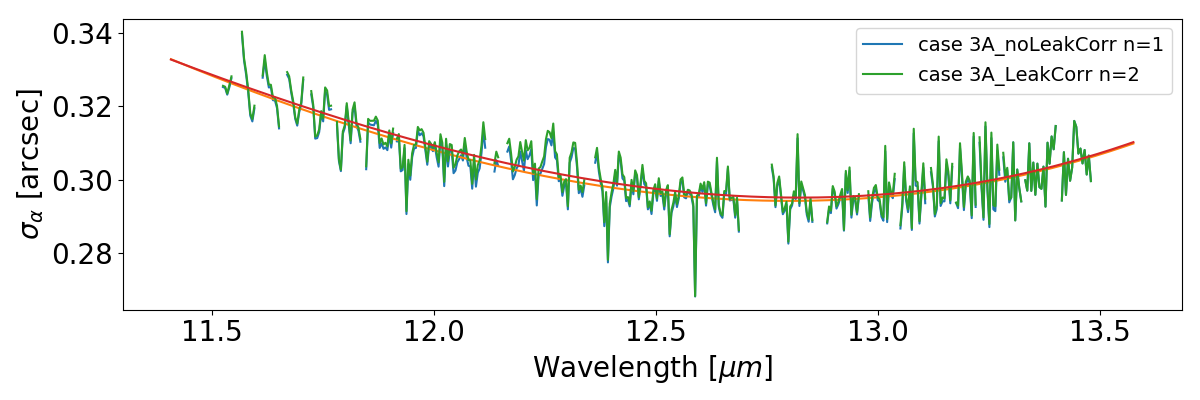

<IPython.core.display.Javascript object>


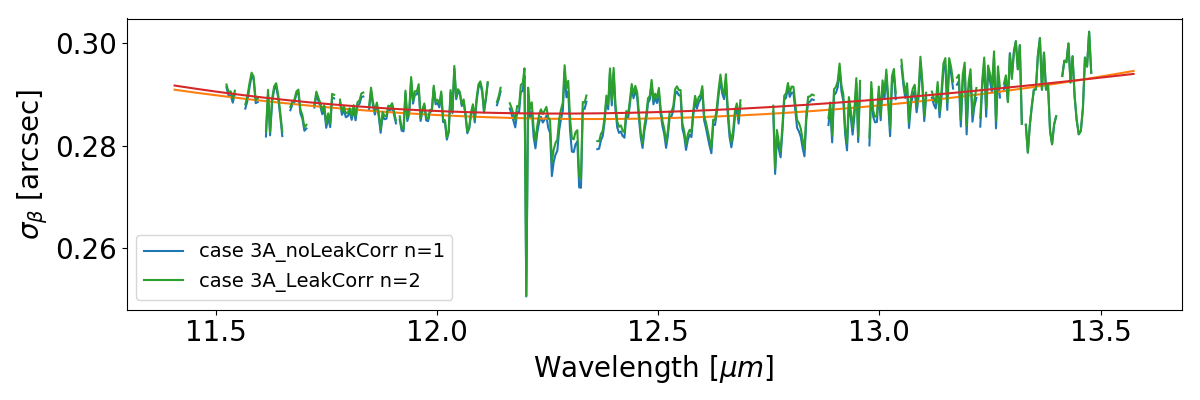

<IPython.core.display.Javascript object>


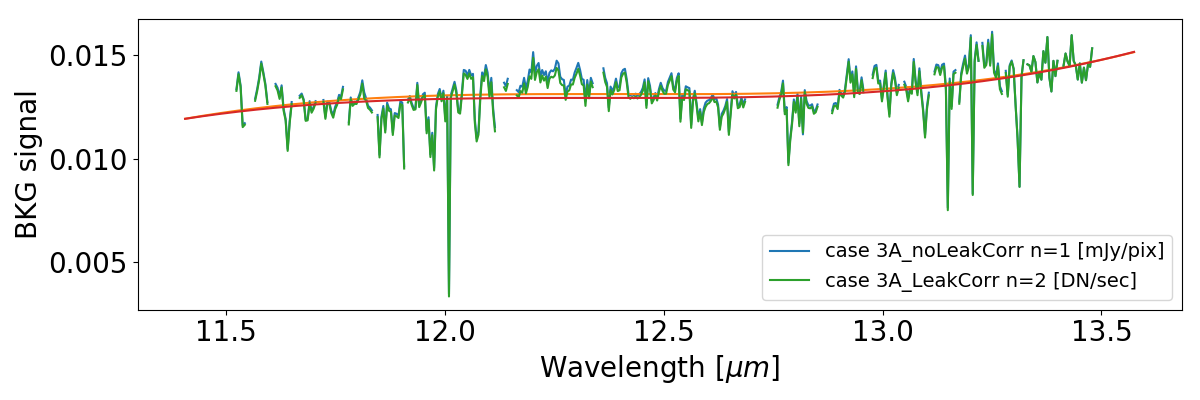

In [73]:
# Manage presence of NaNs by replacing fitted data by fitted polynomials in the spectral dimension
#> signal
sign_amp_poly = {}
sign_amp_poly['3A_noLeakCorr'] = funcs.norm_fringe(sign_amp['3A_noLeakCorr'],thres=0,min_dist=8,k=3,ext=3)[2]
sign_amp_poly['3A_LeakCorr'] = funcs.norm_fringe(sign_amp['3A_LeakCorr'],thres=0,min_dist=8,k=3,ext=3)[2]
    
plt.figure(figsize=(12,4))
plt.plot(lambcens['3A'],sign_amp['3A_noLeakCorr'],label='case 3A_noLeakCorr n=1 [mJy/pix]')
plt.plot(lambcens['3A'],sign_amp_poly['3A_noLeakCorr'])
plt.plot(lambcens['3A'],sign_amp['3A_LeakCorr'],label='case 3A_LeakCorr n=2 [DN/sec]')
plt.plot(lambcens['3A'],sign_amp_poly['3A_LeakCorr'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('SCI signal')
plt.legend(loc='upper right')
plt.tight_layout()

#> along-slice position
alpha_poly = {}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    popt     = np.polyfit(lambcens['3A'][~np.isnan(alpha_centers[case])],alpha_centers[case][~np.isnan(alpha_centers[case])],3)
    poly     = np.poly1d(popt)
    alpha_poly[case] = poly(lambcens['3A'])

plt.figure(figsize=(12,4))
plt.plot(lambcens['3A'],alpha_centers['3A_noLeakCorr'],label='case 3A_noLeakCorr n=1')
plt.plot(lambcens['3A'],alpha_poly['3A_noLeakCorr'])
plt.plot(lambcens['3A'],alpha_centers['3A_LeakCorr'],label='case 3A_LeakCorr n=2')
plt.plot(lambcens['3A'],alpha_poly['3A_LeakCorr'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\alpha$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> across-slice position
beta_poly = {}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    popt     = np.polyfit(lambcens['3A'][~np.isnan(beta_centers[case])],beta_centers[case][~np.isnan(beta_centers[case])],3)
    poly     = np.poly1d(popt)
    beta_poly[case] = poly(lambcens['3A'])

plt.figure(figsize=(12,4))
plt.plot(lambcens['3A'],beta_centers['3A_noLeakCorr'],label='case 3A_noLeakCorr n=1')
plt.plot(lambcens['3A'],beta_poly['3A_noLeakCorr'])
plt.plot(lambcens['3A'],beta_centers['3A_LeakCorr'],label='case 3A_LeakCorr n=2')
plt.plot(lambcens['3A'],beta_poly['3A_LeakCorr'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\beta$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> sigma in along-slice position
sigma_alpha_poly = {}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    popt     = np.polyfit(lambcens['3A'][~np.isnan(sigma_alpha[case])],sigma_alpha[case][~np.isnan(sigma_alpha[case])],3)
    poly     = np.poly1d(popt)
    sigma_alpha_poly[case] = poly(lambcens['3A'])

plt.figure(figsize=(12,4))
plt.plot(lambcens['3A'],sigma_alpha['3A_noLeakCorr'],label='case 3A_noLeakCorr n=1')
plt.plot(lambcens['3A'],sigma_alpha_poly['3A_noLeakCorr'])
plt.plot(lambcens['3A'],sigma_alpha['3A_LeakCorr'],label='case 3A_LeakCorr n=2')
plt.plot(lambcens['3A'],sigma_alpha_poly['3A_LeakCorr'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\sigma_{\alpha}$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> sigma in across-slice position
sigma_beta_poly = {}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    popt     = np.polyfit(lambcens['3A'][~np.isnan(sigma_beta[case])],sigma_beta[case][~np.isnan(sigma_beta[case])],3)
    poly     = np.poly1d(popt)
    sigma_beta_poly[case] = poly(lambcens['3A'])

plt.figure(figsize=(12,4))
plt.plot(lambcens['3A'],sigma_beta['3A_noLeakCorr'],label='case 3A_noLeakCorr n=1')
plt.plot(lambcens['3A'],sigma_beta_poly['3A_noLeakCorr'])
plt.plot(lambcens['3A'],sigma_beta['3A_LeakCorr'],label='case 3A_LeakCorr n=2')
plt.plot(lambcens['3A'],sigma_beta_poly['3A_LeakCorr'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel(r'$\sigma_{\beta}$ [arcsec]')
plt.legend(loc='best')
plt.tight_layout()

#> background/baseline signal
bkg_poly = {}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    popt     = np.polyfit(lambcens['3A'][~np.isnan(bkg_signal[case])],bkg_signal[case][~np.isnan(bkg_signal[case])],3)
    poly     = np.poly1d(popt)
    bkg_poly[case] = poly(lambcens['3A'])

plt.figure(figsize=(12,4))
plt.plot(lambcens['3A'],bkg_signal['3A_noLeakCorr'],label='case 3A_noLeakCorr n=1 [mJy/pix]')
plt.plot(lambcens['3A'],bkg_poly['3A_noLeakCorr'])
plt.plot(lambcens['3A'],bkg_signal['3A_LeakCorr'],label='case 3A_LeakCorr n=2 [DN/sec]')
plt.plot(lambcens['3A'],bkg_poly['3A_LeakCorr'])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('BKG signal')
plt.legend(loc='best')
plt.tight_layout()

In [74]:
def Gauss2D_integral(amp,sigma_x,sigma_y,base,x1,x2,y1,y2):
    from scipy import integrate
    a = 1./(2*sigma_x**2)
    b = 1./(2*sigma_y**2)
    f = lambda y, x: amp * np.exp(- ( a * x**2 + b * y**2 ) ) + base

    s = integrate.dblquad(f, x1, x2, lambda x: y1, lambda x: y2)
    return s[0]

i0,a0,b0,sig_alpha,sig_beta,offset,theta = [{} for i in range(7)]
integral_3A = {}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    print case
    i0[case],a0[case],b0[case],sig_alpha[case],sig_beta[case],offset[case],theta[case] = [np.zeros(len(lambcens['3A'])) for i in range(7)]
    integral_3A[case] = np.zeros(len(lambcens['3A']))
    for bin_3A in range(len(lambcens['3A'])):
        coords = (np.abs(d2cMaps['3A']['lambdaMap']-lambcens['3A'][bin_3A])<lambfwhms['3A'][bin_3A]/2.)
        alphas_3A, betas_3A = d2cMaps['3A']['alphaMap'][coords],d2cMaps['3A']['betaMap'][coords]
        if case == '3A_noLeakCorr':
            signals_3A = spectrum[coords]
        elif case == '3A_LeakCorr':
            signals_3A = spectrum_leakCorr[coords]
        sel = ~np.isnan(signals_3A)

        guess = [sign_amp_poly[case][bin_3A],alpha_poly[case][bin_3A],beta_poly[case][bin_3A],sigma_alpha_poly[case][bin_3A],sigma_beta_poly[case][bin_3A],bkg_poly[case][bin_3A]]
        alphabetas = (alphas_3A[sel],betas_3A[sel])
        try:
            popt,pcov = curve_fit(funcs.gauss2d, alphabetas, signals_3A[sel], p0=guess)
            i0[case][bin_3A],a0[case][bin_3A],b0[case][bin_3A],sig_alpha[case][bin_3A],sig_beta[case][bin_3A],offset[case][bin_3A] = popt
            integral_3A[case][bin_3A] = Gauss2D_integral(i0[case][bin_3A],sig_alpha[case][bin_3A],sig_beta[case][bin_3A],offset[case][bin_3A],-10,10,-10,10)
#             print integral_3A[case][bin_3A]
        except:
            i0[case][bin_3A],a0[case][bin_3A],b0[case][bin_3A],sig_alpha[case][bin_3A],sig_beta[case][bin_3A],offset[case][bin_3A] = [np.nan for i in range(6)]
            integral_3A[case][bin_3A] = np.nan

3A_noLeakCorr
3A_LeakCorr


<IPython.core.display.Javascript object>


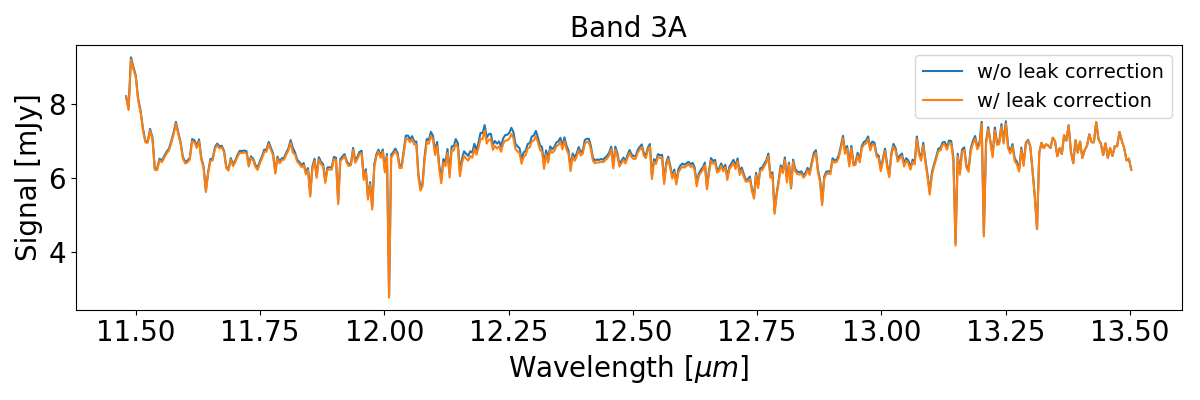

In [75]:
plt.figure(figsize=(12,4))
# plt.plot(lambcens['3A'][15:-15],i0['3A_noLeakCorr'][15:-15],label='w/o leak correction')
# plt.plot(lambcens['3A'][15:-15],i0['3A_LeakCorr'][15:-15],label='w/ leak correction')
plt.plot(lambcens['3A'][15:-15],integral_3A['3A_noLeakCorr'][15:-15],label='w/o leak correction')
plt.plot(lambcens['3A'][15:-15],integral_3A['3A_LeakCorr'][15:-15],label='w/ leak correction')
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('Signal [mJy]')
plt.legend()
plt.title('Band 3A')
plt.tight_layout()

In [26]:
# plt.figure(figsize=(12,4))
# plt.plot(lambcens['3A'][15:-15],sig_alpha['3A_noLeakCorr'][15:-15])
# plt.plot(lambcens['3A'][15:-15],sig_alpha['3A_LeakCorr'][15:-15])
# plt.plot(lambcens['3A'][15:-15],sig_beta['3A_noLeakCorr'][15:-15])
# plt.plot(lambcens['3A'][15:-15],sig_beta['3A_LeakCorr'][15:-15])
# # plt.plot(lambcens['3A'][15:-15],theta['3A_noLeakCorr'][15:-15])
# # plt.plot(lambcens['3A'][15:-15],theta['3A_LeakCorr'][15:-15])
# plt.tight_layout()

In [76]:
snr = {}
sig,noise = {},{}
for case in ['3A_noLeakCorr','3A_LeakCorr']:
    snr[case] = np.zeros(len(lambcens['3A']))
    sig[case] = np.zeros(len(lambcens['3A']))
    noise[case] = np.zeros(len(lambcens['3A']))
    for bin_3A in range(len(lambcens['3A'])):
        coords = (np.abs(d2cMaps['3A']['lambdaMap']-lambcens['3A'][bin_3A])<lambfwhms['3A'][bin_3A]/2.)
        alphas_3A, betas_3A = d2cMaps['3A']['alphaMap'][coords],d2cMaps['3A']['betaMap'][coords]
        if case == '3A_noLeakCorr':
            signals_3A = spectrum[coords]
        elif case == '3A_LeakCorr':
            signals_3A = spectrum_leakCorr[coords]
        sel = ~np.isnan(signals_3A)
        
        popt = [i0[case][bin_3A],a0[case][bin_3A],b0[case][bin_3A],sig_alpha[case][bin_3A],sig_beta[case][bin_3A],offset[case][bin_3A]]
        best = funcs.gauss2d((alphas_3A[sel], betas_3A[sel]),*popt)
        sigma = np.std(signals_3A[sel]-best)
        snr[case][bin_3A] = (best-popt[-1]).sum() / (sigma*len(signals_3A[sel]))
        sig[case][bin_3A] = (best-popt[-1]).sum()
        noise[case][bin_3A] = (sigma*len(signals_3A[sel]))

In [41]:
plt.close('all')

<IPython.core.display.Javascript object>


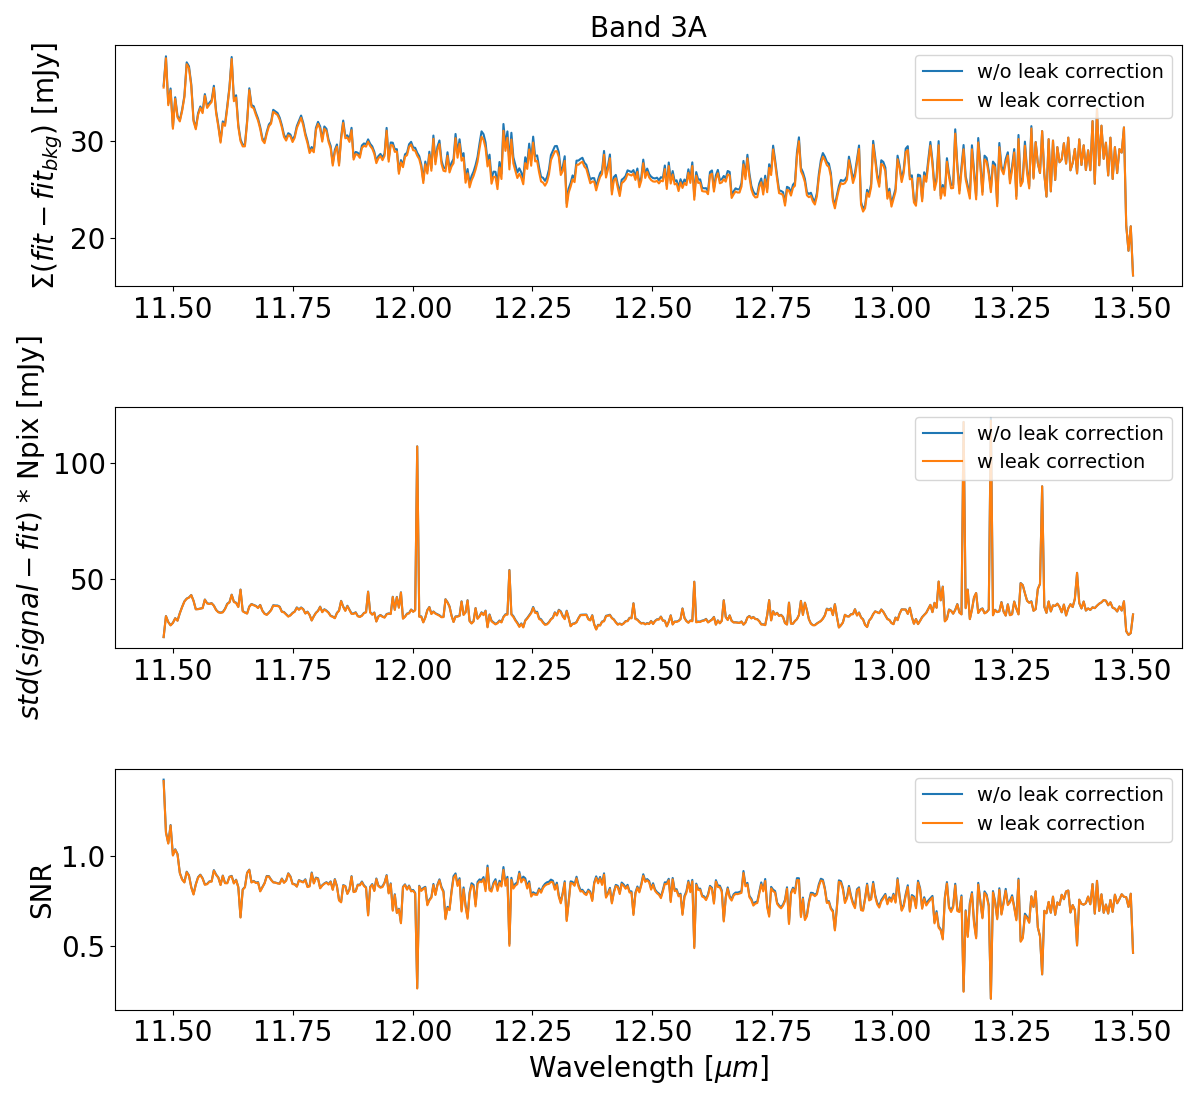

In [77]:
fig,axs = plt.subplots(3,1,figsize=(12,11))
axs[0].plot(lambcens['3A'][15:-15],sig['3A_noLeakCorr'][15:-15],label='w/o leak correction')
axs[0].plot(lambcens['3A'][15:-15],sig['3A_LeakCorr'][15:-15],label='w leak correction')
axs[1].plot(lambcens['3A'][15:-15],noise['3A_noLeakCorr'][15:-15],label='w/o leak correction')
axs[1].plot(lambcens['3A'][15:-15],noise['3A_LeakCorr'][15:-15],label='w leak correction')
axs[2].plot(lambcens['3A'][15:-15],snr['3A_noLeakCorr'][15:-15],label='w/o leak correction')
axs[2].plot(lambcens['3A'][15:-15],snr['3A_LeakCorr'][15:-15],label='w leak correction')
# plt.plot(lambcens['3A'][15:-15],((snr['3A_LeakCorr']-snr['3A_noLeakCorr'])/snr['3A_noLeakCorr'])[15:-15]*100.)
axs[2].set_xlabel('Wavelength [$\mu m$]')
axs[0].set_ylabel('$\Sigma (fit-fit_{bkg})$ [mJy]')
axs[1].set_ylabel('$std(signal-fit)$ * Npix [mJy]')
axs[2].set_ylabel('SNR')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[0].set_title('Band 3A')
plt.tight_layout()

<IPython.core.display.Javascript object>


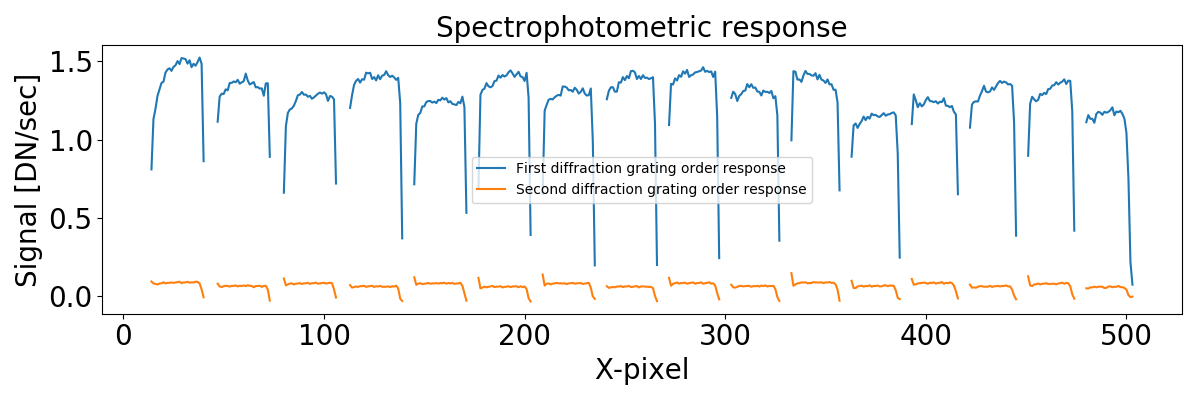

<IPython.core.display.Javascript object>


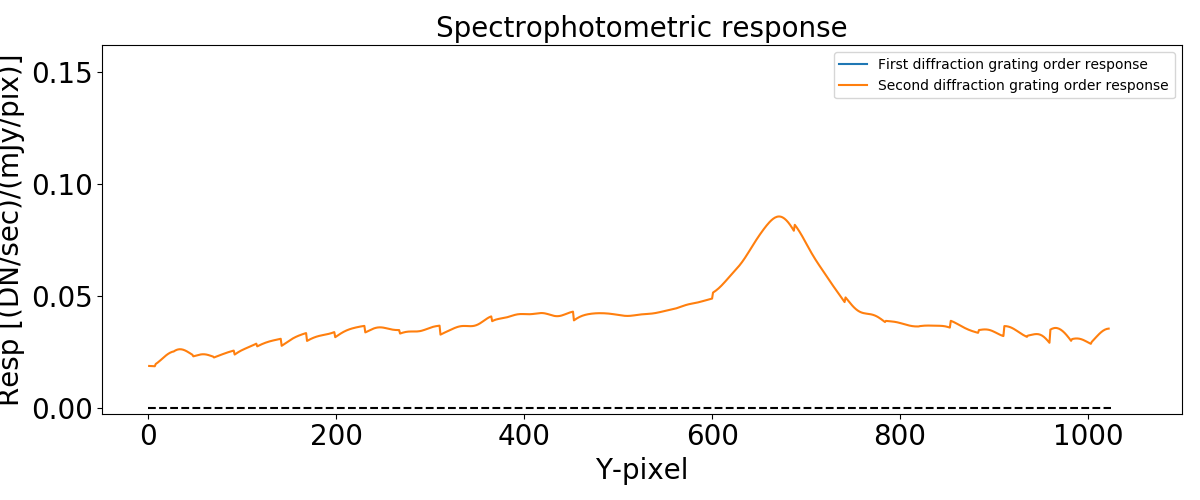

<IPython.core.display.Javascript object>


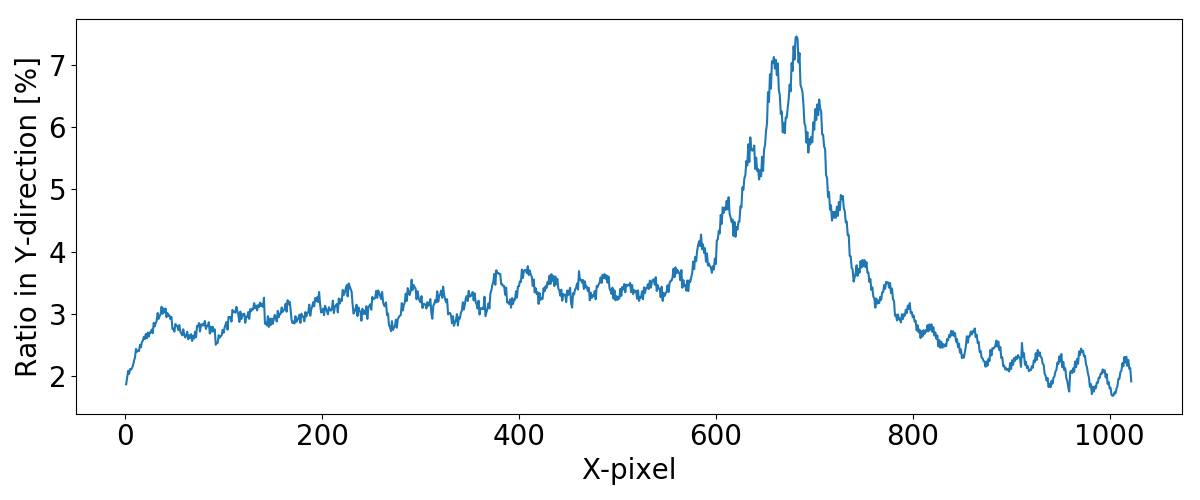

<IPython.core.display.Javascript object>


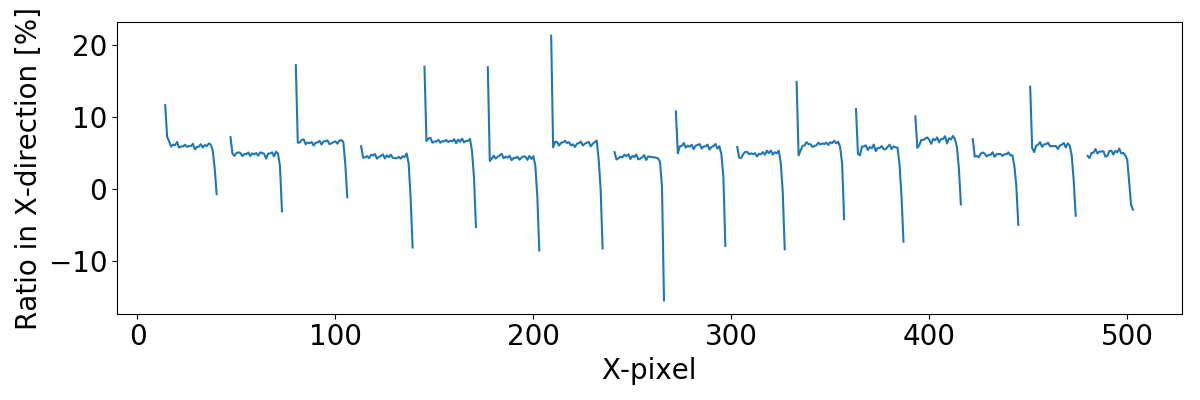

In [67]:
plt.figure(figsize=(12,4))
plt.plot(photom_img['3A'][670,512:],label='First diffraction grating order response')
plt.plot(second_order_response[670,512:],label='Second diffraction grating order response')
plt.xlabel('X-pixel')
plt.ylabel('Signal [DN/sec]')
plt.title('Spectrophotometric response')
plt.legend(fontsize=10)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.plot(photom_img['3A'][:,512+22],label='First diffraction grating order response')
plt.plot(second_order_response[:,512+22],label='Second diffraction grating order response')
plt.hlines(0,0,1024,'k',linestyle='dashed')
plt.xlabel('Y-pixel')
plt.ylabel('Resp [(DN/sec)/(mJy/pix)]')
plt.title('Spectrophotometric response')
plt.legend(fontsize=10)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.plot((second_order_response[:,512+22]/photom_img['3A'][:,512+22])*100)
plt.xlabel('X-pixel')
plt.ylabel('Ratio in Y-direction [%]')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot((second_order_response/photom_img['3A'])[670,512:]*100.)
plt.xlabel('X-pixel')
plt.ylabel('Ratio in X-direction [%]')
plt.legend(fontsize=10)
plt.tight_layout()